In [19]:
# Here is the imports
from tensorflow import keras
import numpy as np
import tensorflow as tf
import segmentation_models as sm
sm.set_framework('tf.keras')
from matplotlib import pyplot as plt
AUTOTUNE = tf.data.AUTOTUNE
import os
import random
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard
# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

<h1>CONSTANTS</h1>

In [16]:
# Dataset Constants
DATASET_PATH = "./recordbase"
TRAIN_DIR = "train"
VAL_DIR = "val"
TEST_DIR = "test"

RECORD_ENCODING_TYPE = "ZLIB" # none if no encoding is used

# Pipeline parameters
BUFFER_SIZE = None # set buffer size to default value, change if you have bottleneck
SHUFFLE_SIZE = 256 # because dataset is too large huge shuffle sizes may cause problems with ram
BATCH_SIZE = 2 # Highly dependent on d-gpu and system ram
STEPS_PER_EPOCH = 5636//BATCH_SIZE # IMPORTANT this value should be equal to file_amount/batch_size because we can't find file_amount from tf.Dataset you should note it yourself
VAL_STEPS_PER_EPOCH = 400//BATCH_SIZE # same as steps per epoch
# every shard is 200 files with 36 files on last shard
# Model Constants
BACKBONE = 'efficientnetb3'
# unlabelled 0, iskemik 1, hemorajik 2
CLASSES = ['iskemik', 'kanama']
LR = 0.0001
EPOCHS = 40
MODEL_SAVE_PATH = "./models"

In [17]:
# Variables
train_dir = os.path.join(DATASET_PATH, TRAIN_DIR)
val_dir = os.path.join(DATASET_PATH, VAL_DIR)

train_filenames = tf.io.gfile.glob(f"{train_dir}/*.tfrecords")
val_filenames = tf.io.gfile.glob(f"{val_dir}/*.tfrecords")

random.shuffle(train_filenames) # shuffle tfrecord files order
random.shuffle(val_filenames)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    TensorBoard(
    log_dir="logs",
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    update_freq="epoch",
    ),
]

# Utility functions 

In [5]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        # if whole binary image is true plt shows it as whole image is false so for bypassing this issue we assing one pixels value to 0
        image[1,1] = 0 
        plt.imshow(image)
    plt.show()

def visualize_dataset(img, mask, classes):
    kwarg = {'image': img}
    for i in range(len(classes)):
        kwarg.update({classes[i] : mask[..., i].squeeze()})
    visualize(**kwarg)

    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def plot_history(train_history):
    # Plot training & validation iou_score values
    plt.figure(figsize=(30, 5))
    plt.subplot(121)
    plt.plot(train_history.history['iou_score'])
    plt.plot(train_history.history['val_iou_score'])
    plt.title('Model iou_score')
    plt.ylabel('iou_score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# Data Input Pipeline (Highly Optimized TFRecord Reader)

In [6]:
def parse_examples_batch(examples):
    feature_description = {
        'image/height' : tf.io.FixedLenFeature([], tf.int64),
        'image/width' : tf.io.FixedLenFeature([], tf.int64),
        'image/depth' : tf.io.FixedLenFeature([], tf.int64),
        'image/raw_image' : tf.io.FixedLenFeature([], tf.string),
        'label/raw' : tf.io.FixedLenFeature([], tf.string)
    }
    samples = tf.io.parse_example(examples, feature_description)
    return samples

def prepare_sample(features):
    image = tf.vectorized_map(lambda x: tf.io.parse_tensor(x, out_type = tf.uint8), features["image/raw_image"])
    label = tf.vectorized_map(lambda x: tf.io.parse_tensor(x, out_type = tf.double), features["label/raw"])
    return image, label

def get_dataset_optimized(filenames, batch_size, shuffle_size):
    return (tf.data.TFRecordDataset(filenames, compression_type=RECORD_ENCODING_TYPE, num_parallel_reads=AUTOTUNE)
    .shuffle(shuffle_size) # maybe change this to batch_size * 10
    .batch(batch_size=batch_size)
    .map(map_func=parse_examples_batch, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(map_func=prepare_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .cache()
    .prefetch(tf.data.experimental.AUTOTUNE))

# Sanity Check Dataset

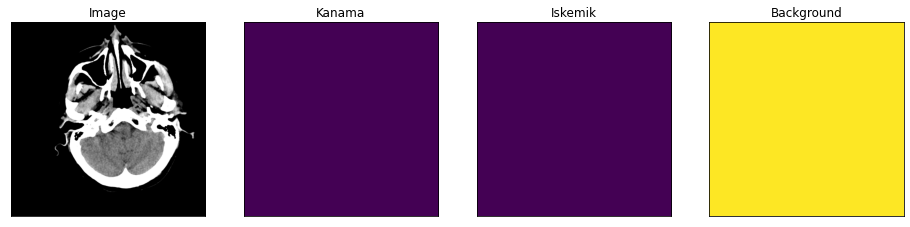

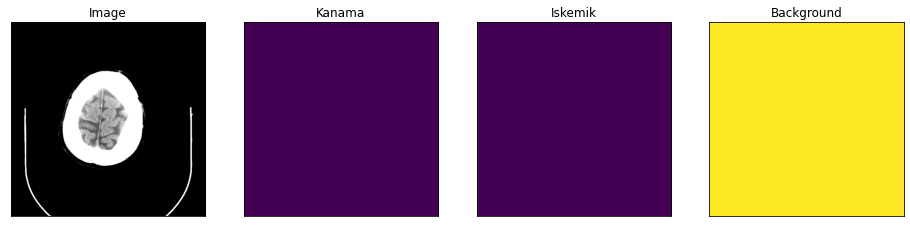

In [9]:
sanity_dataset = get_dataset_optimized(train_filenames, BATCH_SIZE, SHUFFLE_SIZE)

i = sanity_dataset.take(1)
for x in i:
    for k in range(0, 2):
        img, mask = x
        visualize_dataset(img[k].numpy(), mask[k].numpy(), ["kanama", "iskemik", "background"])

# Create Model

In [ ]:
def model_factory() -> keras.models.Model:
    # define network parameters
    n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
    activation = 'sigmoid' if n_classes == 1 else 'softmax'

    #create model
    model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

    # define optomizer
    optim = keras.optimizers.Adam(LR)

    # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
    # set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
    # TODO redefine class weights
    dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
    focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)

    # actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
    # total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

    # compile keras model with defined optimozer, loss and metrics
    model.compile(optim, total_loss, metrics)
    return model

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
# TODO redefine class weights
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
history = model.fit(
        get_dataset_optimized(train_filenames, BATCH_SIZE, SHUFFLE_SIZE), 
        steps_per_epoch=STEPS_PER_EPOCH, 
        epochs=EPOCHS, 
        callbacks=callbacks, 
        validation_data=get_dataset_optimized(val_filenames, BATCH_SIZE, SHUFFLE_SIZE), 
        validation_steps=VAL_STEPS_PER_EPOCH,
    )
# TODO make this after eval for writing accuracy in the model name
model_name = f"{history.history['val_iou_score']}iou_{datetime.now().strftime("%H_%M_%d_%m_%Y")}"
save_path = os.path.join(MODEL_SAVE_PATH, f"{model_name}.h5")
model.save(save_path)

# Train the Model

In [ ]:
def train_model(data_generators, model, callbacks):
    train_dataloader = data_generators[0]
    valid_dataloader = data_generators[1]
    # train model
    history = model.fit(
        train_dataloader, 
        steps_per_epoch=len(train_dataloader), 
        epochs=EPOCHS, 
        callbacks=callbacks, 
        validation_data=valid_dataloader, 
        validation_steps=len(valid_dataloader),
    )
    # TODO make this after eval for writing accuracy in the model name
    save_path = os.path.join(MODEL_SAVE_PATH, f"{}acc_{}.{}")
    model.save(save_path)

# Evaluate Model

In [ ]:
def evaluate_model(eval_generator, model):
    pass

In [4]:
model_double_unet = sm.custom.Double_Unet(backbone_name="vgg19", encoder_weights=None, input_shape=(512,512,3), classes=6)
# for the class problem solution is simple make softmax like sigmoid, if background class has the heighest probility count that pixel as 0
# if another class is higher count that as 1. think about another way to make 2nd model consider whole image. Also in the last layer
# you can add class probility


Starting up Double Unet initialization...
Processing settings...
Settings initialized. Starting to build model.
ASPP-1 initialized...
Decoder-1 initialized...
Output-1 initialized...
output is KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 6), dtype=tf.float32, name=None), name='activation_3/Softmax:0', description="created by layer 'activation_3'")
x is KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 6), dtype=tf.float32, name=None), name='tf.math.multiply_2/Mul:0', description="created by layer 'tf.math.multiply_2'")
Encoder-2 initialized...
ASPP-2 initialized...
Decoder-2 initialized...
Output-2 initialized...
Model initialization complete.


In [ ]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback = TensorBoard(
    log_dir="logs",
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    update_freq="epoch",
)

In [ ]:
model_double_unet.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_double_unet.fit(X_train, y_train, batch_size = 32, epochs = 50, callbacks=[tensorboard_callback])